In [21]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(str(Path.cwd().parent/'scripts'))
from _helpers import to_datetime

In [22]:
root = Path.cwd().parent / "resources" / "live_data"

prices = []
bmus = []
timestamps = []

for fn in tqdm(os.listdir(root)):

    date, period = fn.split('_')
    date = to_datetime(date, period)

    files = os.listdir(root / fn)
    if 'elexon_bmus.csv' in files and 'price_stats.csv' in files:

        bmu = pd.read_csv(root / fn / 'elexon_bmus.csv', index_col=0)

        bmus.append(bmu[['PN']].rename(columns={'PN': date}))

        price = pd.read_csv(root / fn / 'price_stats.csv', index_col=0)
        prices.append(price.iloc[0,0])
        timestamps.append(date)

bmus = pd.concat(bmus, axis=1).T
prices = pd.Series(prices, timestamps)
ts = prices.index

  0%|          | 0/8865 [00:00<?, ?it/s]

100%|██████████| 8865/8865 [04:43<00:00, 31.32it/s] 


      STAY-2   price
0      436.0  207.22
1      436.0  202.61
2      427.0  195.73
3      427.0  192.31
4      433.0  191.77
...      ...     ...
8186     0.0  -65.02
8187     0.0  -69.58
8188     0.0  -71.33
8189     0.0  -72.97
8190     0.0  -73.24

[8191 rows x 2 columns]


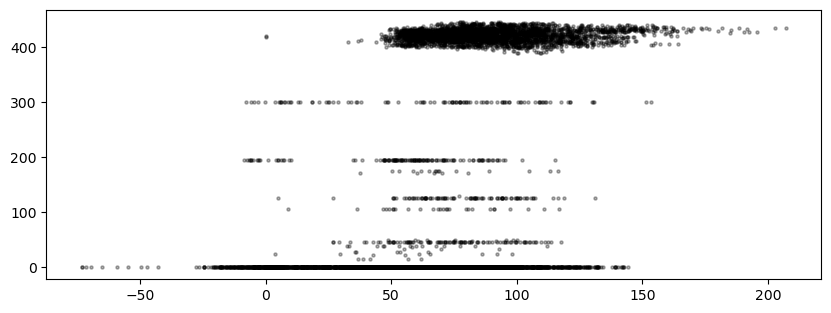

In [60]:
def bmu_analyis(dispatch, prices):

    assert (dispatch.index == prices.index).all()

    df = (
        pd.concat((dispatch, prices), axis=1)
        .rename(columns={0: 'price'})
        .sort_values(by='price', ascending=False)
    )
    df.index = range(len(df))

    fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

    print(df)
    ax.scatter(df.price.values, df.iloc[:,0], color='k', s=5, alpha=0.3)

    plt.show()


unit = "STAY-2"

bmu_analyis(bmus[unit], prices)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


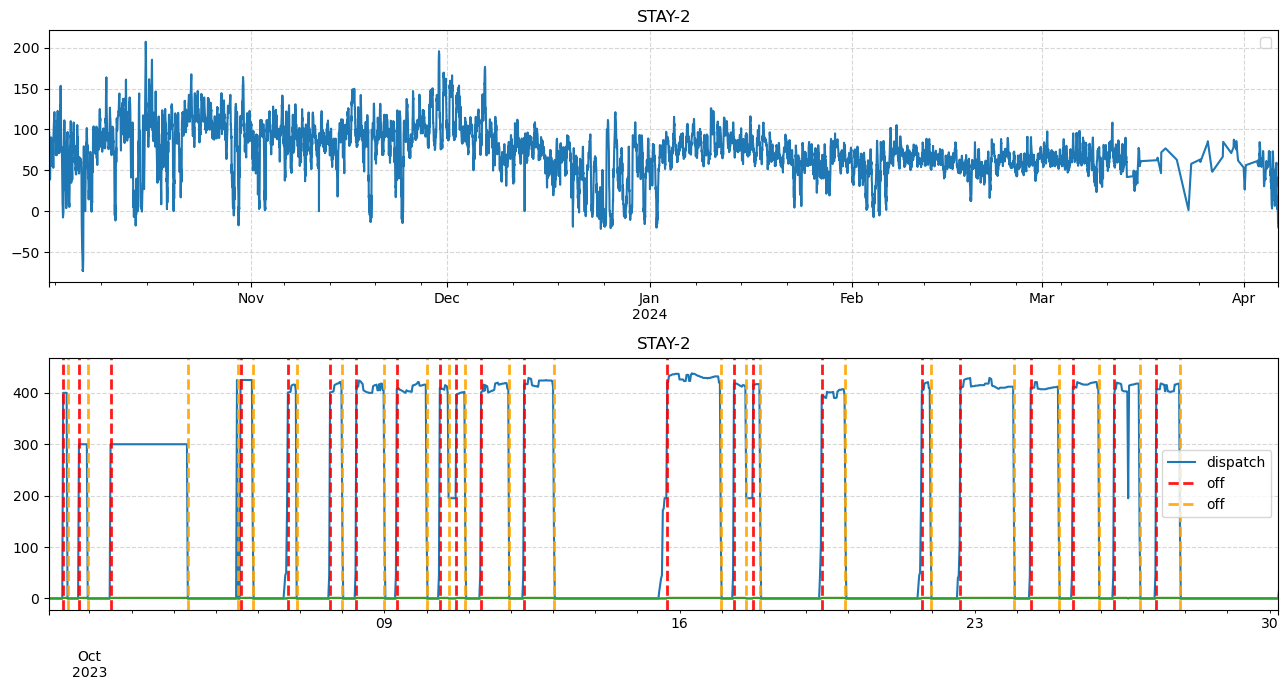

In [217]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import argrelextrema

def get_extremes(dispatch, mode='on', neighbour_filter=10):
    """
    Returns indices of timeseries of dispatch in which a generator is switched on or off.
    Works for high-cost peak-demand meeting generators 
    
    Parameters
    ----------
    dispatch : pd.Series
        Timeseries of dispatch
    mode : str, optional
        'on' or 'off', by default 'on'; on to return times of on-switching else off-switching
    """

    if isinstance(dispatch, pd.DataFrame):
        assert len(dispatch.columns) == 0, 'unclear how to handle multiple columns in dispatch dataframe'
        dispatch = dispatch.iloc[:,0]

    if dispatch.max() > 1.:
        dispatch = pd.Series(
            MinMaxScaler().fit_transform(dispatch.values.reshape(-1, 1)).flatten(),
            index=dispatch.index
        )
    
    rounded = dispatch.fillna(0.).round()

    rounded.plot()

    deriv_window_size = 10
    deriv = (
        rounded
        .rolling(deriv_window_size, center=True)
        .apply(lambda x: x[deriv_window_size//2:].mean() - x[:deriv_window_size//2].mean())
    )

    if mode == 'on':
        extreme_func = np.less_equal
    elif mode == 'off':
        extreme_func = np.greater_equal
    else:
        raise ValueError('mode must be either "on" or "off"')

    extremes = np.array(argrelextrema(deriv.values, extreme_func, order=5)[0])

    extremes = extremes[deriv.iloc[extremes] != 0]

    # minor cleanup; remove neighbouring values
    mask = np.abs(np.roll(extremes, 1) - extremes) < neighbour_filter
    mask = mask + np.roll(mask, -1)

    extremes = extremes[~mask]
    
    return extremes


full_index = pd.date_range(prices.index[0], prices.index[-1], freq='30T')

fig, axs = plt.subplots(2, 1, figsize=(13, 7))
prices.plot(ax=axs[0])
p = bmus[unit]

prices = prices.reindex(full_index).interpolate()
p = p.reindex(full_index).interpolate()

p.plot(ax=axs[1], label='dispatch')

switchons = get_extremes(p, mode='on')
switchoffs = get_extremes(p, mode='off')

for i, n in enumerate(switchoffs):

    if i == 0:
        label = 'off'
    else:
        label = None
    axs[1].axvline(p.index[n], color='r', linestyle='--', alpha=0.9, label=label, linewidth=2)

for i, n in enumerate(switchons):

    if i == 0:
        label = 'off'
    else:
        label = None

    axs[1].axvline(p.index[n], color='orange', linestyle='--', alpha=0.9, label=label, linewidth=2)

switchons = pd.Index([p.index[n] for n in switchons])
switchoffs = pd.Index([p.index[n] for n in switchoffs])

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    ax.set_title(unit)

ax.set_xlim(full_index[0], full_index[1400])
plt.tight_layout()
plt.show()



In [223]:
# print(switchons)
# print(switchoffs)

diffs = []
for on in switchons:

    diffs.append(off - on)

'''
avg_price_frames = [
    (on, switchoffs[on:][0]) for on in switchons if len(switchoffs[on:]) > 0
]
avg_prices = [
    prices.loc[on:off].mean() for on, off in avg_price_frames
]
'''

2023-10-01 11:30:00 -> 2023-10-01 18:00:00
2023-10-01 23:00:00 -> 2023-10-02 12:00:00
2023-10-04 08:00:00 -> 2023-10-05 14:00:00
2023-10-05 12:30:00 -> 2023-10-06 17:00:00
2023-10-05 21:00:00 -> 2023-10-07 17:00:00
2023-10-06 22:00:00 -> 2023-10-08 08:00:00
2023-10-08 00:00:00 -> 2023-10-09 07:00:00
2023-10-09 00:00:00 -> 2023-10-10 07:30:00
2023-10-10 00:00:00 -> 2023-10-10 17:00:00
2023-10-10 12:30:00 -> 2023-10-11 07:00:00
2023-10-10 22:00:00 -> 2023-10-12 07:30:00
2023-10-11 23:00:00 -> 2023-10-15 17:00:00
2023-10-13 00:30:00 -> 2023-10-17 07:00:00
2023-10-16 23:30:00 -> 2023-10-17 18:00:00
2023-10-17 14:00:00 -> 2023-10-19 09:00:00
2023-10-17 22:00:00 -> 2023-10-21 18:00:00
2023-10-19 22:30:00 -> 2023-10-22 16:00:00
2023-10-21 23:00:00 -> 2023-10-24 08:00:00
2023-10-23 22:30:00 -> 2023-10-25 08:00:00
2023-10-25 00:00:00 -> 2023-10-26 07:30:00
2023-10-25 23:00:00 -> 2023-10-27 07:30:00
2023-10-26 22:00:00 -> 2023-10-30 08:00:00
2023-10-27 21:00:00 -> 2023-10-31 08:00:00
2023-10-30 

'\navg_price_frames = [\n    (on, switchoffs[on:][0]) for on in switchons if len(switchoffs[on:]) > 0\n]\navg_prices = [\n    prices.loc[on:off].mean() for on, off in avg_price_frames\n]\n'

In [227]:
np.median(np.array(diffs))

Timedelta('1 days 10:00:00')

<AxesSubplot:>

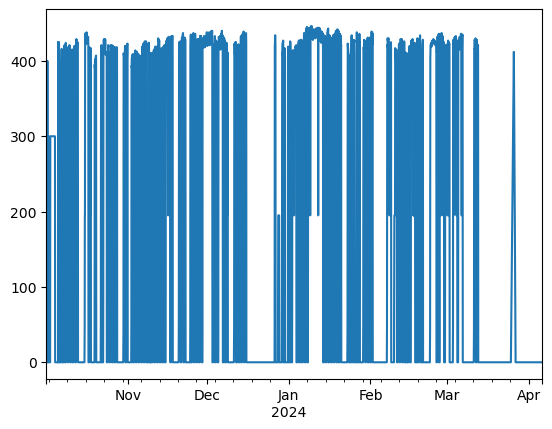

In [222]:
p.plot()

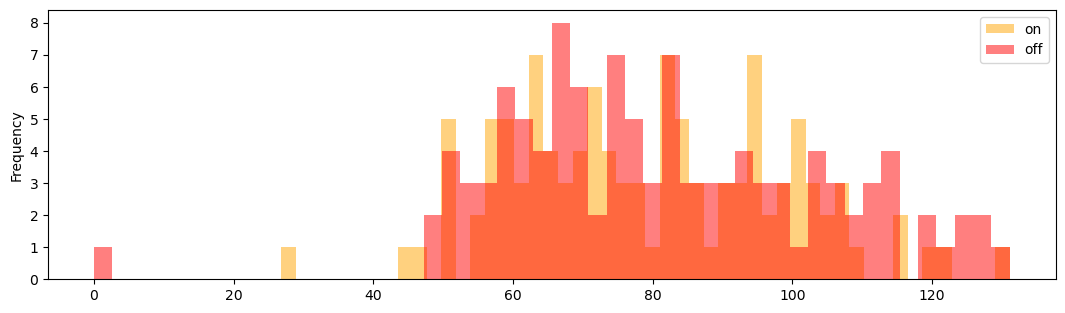

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3.5))

prices.loc[switchons].plot.hist(ax=ax, bins=50, alpha=0.5, color='orange', label='on')
prices.loc[switchoffs].plot.hist(ax=ax, bins=50, alpha=0.5, color='r', label='off')
avg_prices = pd.Series(avg_prices, index=switchons)

ax.legend()
plt.show()

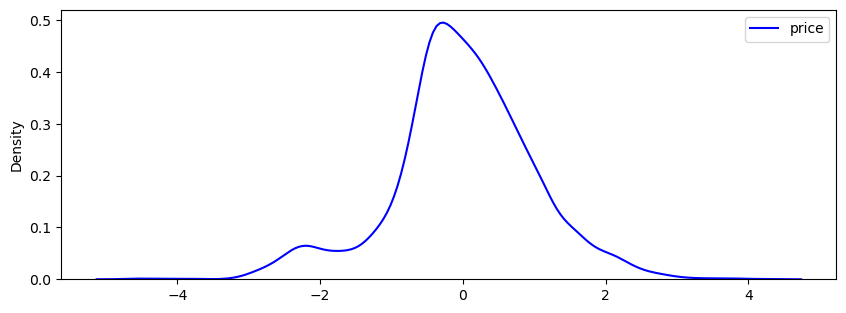

In [87]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

sns.kdeplot(StandardScaler().fit_transform(df[['price']]).flatten(), ax=ax, color='blue', label='price')

ax.legend()
plt.show()

In [79]:
df

,STAY-2,price
2023-10-15 20:00:00,436.0,207.22
2023-10-15 20:30:00,436.0,202.61
2023-11-29 17:30:00,427.0,195.73
2023-11-29 18:00:00,427.0,192.31
2023-11-29 18:30:00,433.0,191.77
...,...,...
2023-10-06 06:00:00,0.0,-65.02
2023-10-06 04:00:00,0.0,-69.58
2023-10-06 05:00:00,0.0,-71.33
2023-10-06 04:30:00,0.0,-72.97


In [51]:
bmus.sum().sort_values(ascending=False).iloc[20:50]

HOWBO-3      2261715.0
HOWBO-1      2242113.0
HOWBO-2      2215941.0
HRTL-2       2156674.0
TKNEW-1      2041005.0
TKNWW-1      2025120.0
PEMB-51      1968381.0
EAAO-2       1967128.0
GRAI-7       1912712.0
PEMB-41      1908920.0
HEYM12       1863598.0
LBAR-1       1840562.0
HOWAO-1      1837527.0
PEMB-31      1833114.0
GRAI-6       1763618.0
SEAB-1       1755842.0
EAAO-1       1727384.0
PEMB-21      1724089.0
CDCL-1       1664721.0
IFG-INCM1    1662408.0
SHOS-1       1651778.0
PEMB-11      1634244.0
SCCL-2       1626201.0
GRAI-8       1617658.0
HOWAO-3      1601472.0
STAY-2       1566174.0
HOWAO-2      1554448.0
SGRWO-6      1539269.0
TSREP-1      1538145.0
WLNYO-4      1528705.0
dtype: float64